# Rain events


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.lines import Line2D

from fault_management_uds.data.load import import_external_metadata, import_metadata
from fault_management_uds.data.HDF5_functions import print_tree, load_dataframe_from_HDF5
from fault_management_uds.plots import visualize_indicator_dict



from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR


2024-11-15 13:07:45.302 | INFO     | fault_management_uds.config:<module>:11 - PROJ_ROOT path is: /Users/arond.jacobsen/Documents/GitHub/fault_management_uds


### Load rain data

In [2]:
data_file_path = PROCESSED_DATA_DIR / 'Bellinge.h5'
f = print_tree(data_file_path)

root
├── combined_data
│   ├── clean
│   │   ├── columns
│   │   ├── data
│   │   └── timestamps
│   └── raw
│       ├── columns
│       ├── data
│       └── timestamps
└── single_series
    ├── rain_gauge_data
    │   ├── 5425
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   └── 5427
    │       ├── columns
    │       ├── data
    │       └── timestamps
    └── sewer_data
        ├── G71F04R_Level1
        │   ├── bools
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │   ├── clean
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │   └── raw
        │       ├── columns
        │       ├── data
        │       └── timestamps
        ├── G71F04R_Level2
        │   ├── bools
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │   ├── clean
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │ 

Only focus on 5425 since seems to be closest and most relevant

In [3]:
sensor_metadata = import_metadata(REFERENCE_DIR / 'sensor_metadata.csv')
starttime = sensor_metadata['StartTime'].min()
endtime = sensor_metadata['EndTime'].max()

## Rainfall events


classify rain events, each event can be defined as:
1. The event starts when the rain gauge is not zero
2. The event ends when the rain gauge is zero
3. The event has to be at least 30 minutes long
5. The event has to have at least 2 mm of rain in total
6. The event is 'relaxed' in case of zero gaps of 15 minutes

- there is a standard for this

In [4]:

def classify_rain_events(rain_data):
    # Thresholds
    min_event_duration = 30  # in minutes
    min_event_rainfall = 10  # in mm
    max_zero_gap = 15  # in minutes
    
    # Ensure time as the index (assuming your index is time-based)
    rain_data = rain_data.reset_index(drop=False, names='time')

    # Initialize variables for tracking events
    events = [] # List to store the events
    current_event = [] # List to store the current ongoing event
    zero_streak = 0 # Counter for the number of zero values
    
    for i, row in tqdm(rain_data.iterrows(), total=len(rain_data), desc='Classifying rain events'):
        # Check if it's raining
        if row['value'] > 0:
            # If there's no ongoing event, start a new one
            if not current_event:
                current_event_start_time = row.time
            current_event.append(row)
            zero_streak = 0  # Reset zero streak since it's raining
            
        # Check if it's not raining
        elif row['value'] == 0 and current_event:
            zero_streak += 1  # Increase zero streak
            if zero_streak <= max_zero_gap:
                # Still within the relaxed gap period, consider it part of the event
                current_event.append(row)
            else:
                # Zero streak exceeds allowed gap, event ends here, but take the before the zero streak
                event_end_time = rain_data.loc[i - zero_streak, 'time']
                
                # Create a DataFrame for the event and apply filtering
                event_df = pd.DataFrame(current_event)
                event_duration = round((event_df.time.max() - event_df.time.min()).total_seconds() / 60.0)  # in minutes
                total_rain = event_df['value'].sum()
                
                # Check if the event meets the criteria
                if event_duration >= min_event_duration and total_rain >= min_event_rainfall:
                    events.append({
                        'start': current_event_start_time,
                        'end': event_end_time,
                        'duration': event_duration,
                        'total_rain': total_rain
                    })
                
                # Reset the current event tracking
                current_event = []
                zero_streak = 0

    # After looping, check if there's a valid ongoing event
    if current_event:
        event_df = pd.DataFrame(current_event)
        event_duration = (event_df['time'].max() - event_df['time'].min()).total_seconds() / 60.0
        total_rain = event_df['value'].sum()
        if event_duration >= min_event_duration and total_rain >= min_event_rainfall:
            events.append({
                'start': current_event_start_time,
                'end': event_df['time'].max(),
                'duration': event_duration,
                'total_rain': total_rain
            })
    
    return pd.DataFrame(events)


In [5]:
# # load clean and bools for the whole dataset and create the indicator
# rain_5425, _, _, _ = load_dataframe_from_HDF5(data_file_path, 'single_series/rain_gauge_data/5425', starttime=starttime, endtime=endtime, complete_range=True)
# # get the rain series, unit is mm/minute
# rain_events_5425 = classify_rain_events(rain_5425)
# # save the rain events as csv
# rain_events_5425.to_csv(REFERENCE_DIR / 'clf_rain_events.csv', index=False)
# print(rain_events_5425.shape)

### Load

In [6]:
# load the rain events
rain_events = pd.read_csv(REFERENCE_DIR / 'clf_rain_events.csv')
rain_events['start'] = pd.to_datetime(rain_events['start'])
rain_events['end'] = pd.to_datetime(rain_events['end'])
print(rain_events.shape)
rain_events.head()

(2033, 4)


,start,end,duration,total_rain
0,2010-01-11 18:37:00,2010-01-12 03:12:00,530,123.296
1,2010-01-27 13:53:00,2010-01-27 16:17:00,159,36.689
2,2010-01-29 23:51:00,2010-01-30 02:21:00,165,43.327
3,2010-01-31 02:53:00,2010-01-31 03:48:00,70,23.345
4,2010-02-02 11:22:00,2010-02-02 15:20:00,253,69.968


## Rain events timeline

In [7]:
# get timestamps
timestamps = pd.date_range(starttime, endtime, freq='1min')
# count minutes from starttime to endtime
n_obs = len(timestamps)
rain_indicator = np.zeros(n_obs)
for i, row in rain_events.iterrows():
    start = timestamps.get_loc(row['start'])
    end = timestamps.get_loc(row['end'])
    rain_indicator[start:end] = 1

In [8]:
rain_indicator_dict = {
    'Rain Events': {
        'indicator': rain_indicator,
        'colormap': {
            0: 'antiquewhite',
            1: 'lightskyblue'
        }
    }
}

In [9]:
save_folder = FIGURES_DIR / 'analysis' / 'rain_events'
os.makedirs(save_folder, exist_ok=True)

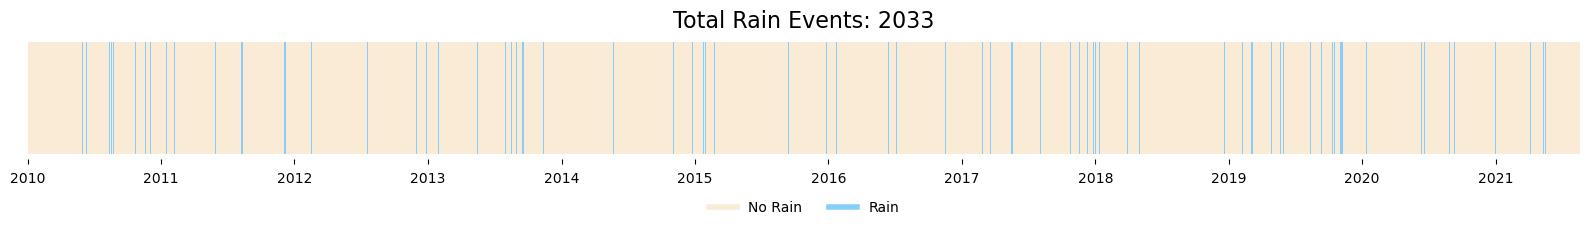

In [10]:
fig, ax = plt.subplots(figsize=(16, 2))
ax = visualize_indicator_dict(ax, rain_indicator_dict, start=starttime, end=endtime, adjust='half-point', ylabel=f'Total Rain Events: {rain_events.shape[0]}')
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False); ax.spines['left'].set_visible(False); ax.spines['bottom'].set_visible(False);
# place legend under the plot and define the number of columns, and specify name-colors
# Create custom legend entries
custom_lines = [
    Line2D([0], [0], color='antiquewhite', lw=4, label='No Rain'),
    Line2D([0], [0], color='lightskyblue', lw=4, label='Rain')
]
ax.set_yticks([])
plt.tight_layout()
ax.set_title(f'Total Rain Events: {rain_events.shape[0]}', fontsize=16)
ax.legend(handles=custom_lines, loc='lower center', ncol=2, frameon=False, bbox_to_anchor=(0.5, -0.55))
# save
fig.savefig(save_folder / 'timeline.png', dpi=500)
plt.show()
plt.close()

## Distributions

Total rain

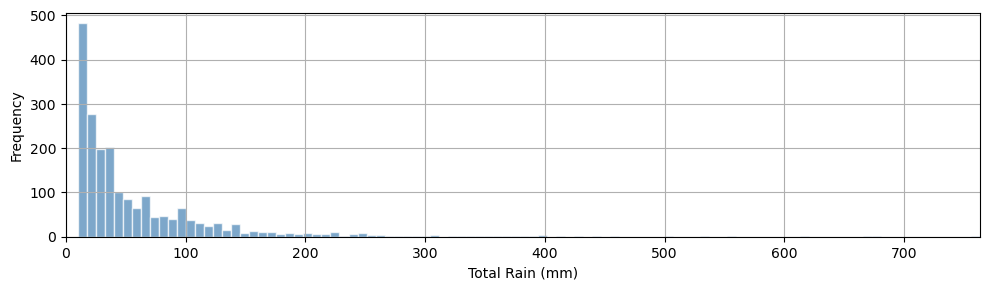

In [11]:
# visualize histrogram for duration
fig, ax = plt.subplots(figsize=(10, 3), dpi=100)
rain_events.total_rain.hist(bins=100, ax=ax, color='#4682b4', alpha=0.7, edgecolor='white')
ax.set_xlim(0, max(rain_events.total_rain))
#ax.set_title('Total Rain (mm) Distribution')
ax.set_xlabel('Total Rain (mm)')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.savefig(save_folder / 'total_rain_distribution.png', dpi=100)
plt.show()
plt.close()

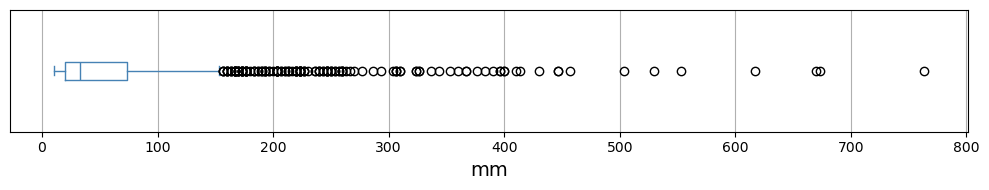

In [12]:
# visualize histrogram for duration
fig, ax = plt.subplots(figsize=(10, 2), dpi=100)
# boxplot
rain_events.boxplot(column='total_rain', ax=ax, vert=False, color='#4682b4')
#ax.set_title('Total Rain (mm) for Each Event')
ax.set_xlabel('mm', fontsize=14)
# remove y-axis
ax.set_yticks([])
plt.tight_layout()
plt.savefig(save_folder / 'total_rain_boxplot.png', dpi=100)
plt.show()
plt.close()


Duration

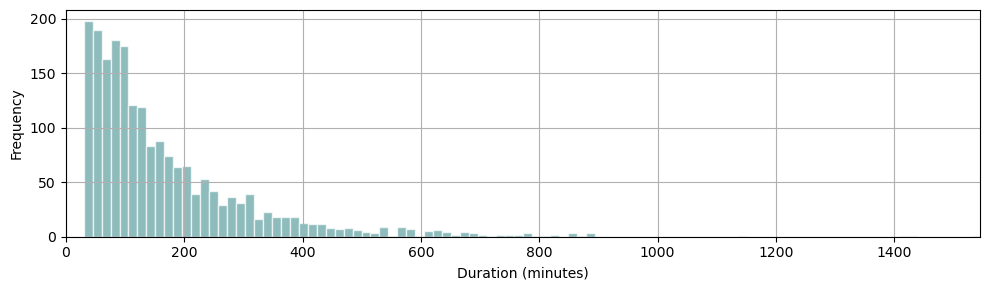

In [13]:
# visualize histrogram for duration
fig, ax = plt.subplots(figsize=(10, 3), dpi=100)
rain_events.duration.hist(bins=100, ax=ax, color='#5f9ea0', alpha=0.7, edgecolor='white')
ax.set_xlim(0, max(rain_events.duration))
#ax.set_title('Total Rain (mm) Distribution')
ax.set_xlabel('Duration (minutes)')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.savefig(save_folder / 'duration_hist.png', dpi=100)
plt.show()
plt.close()

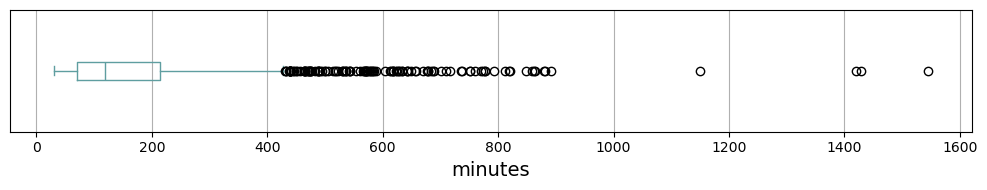

In [14]:
# visualize histrogram for duration
fig, ax = plt.subplots(figsize=(10, 2), dpi=100)
# boxplot
rain_events.boxplot(column='duration', ax=ax, vert=False, color='#5f9ea0')
#ax.set_title('Total Rain (mm) for Each Event')
ax.set_xlabel('minutes', fontsize=14)
# remove y-axis
ax.set_yticks([])
plt.tight_layout()
plt.savefig(save_folder / 'duration_boxplot.png', dpi=100)
plt.show()
plt.close()

Intensity

In [15]:
rain_events['intensity'] = rain_events['total_rain'] / rain_events['duration']

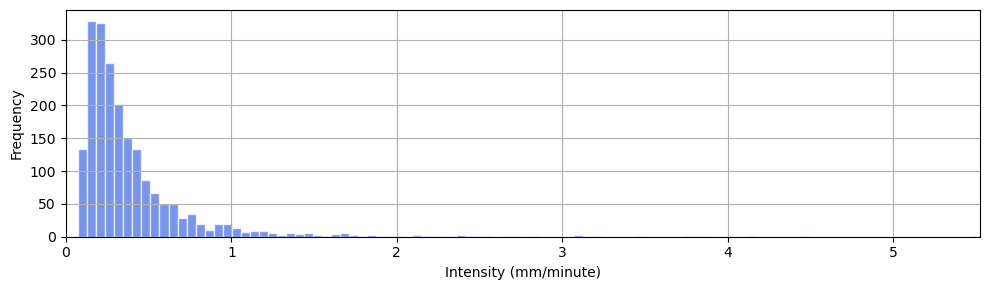

In [16]:
# visualize histrogram for duration
fig, ax = plt.subplots(figsize=(10, 3), dpi=100)
rain_events.intensity.hist(bins=100, ax=ax, color='#4169e1', alpha=0.7, edgecolor='white')
ax.set_xlim(0, max(rain_events.intensity))
#ax.set_title('Total Rain (mm) Distribution')
ax.set_xlabel('Intensity (mm/minute)')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.savefig(save_folder / 'intensity_hist.png', dpi=100)
plt.show()
plt.close()

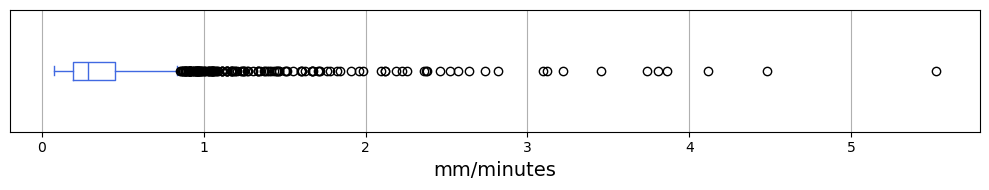

In [17]:
# visualize histrogram for duration
fig, ax = plt.subplots(figsize=(10, 2), dpi=100)
# boxplot
rain_events.boxplot(column='intensity', ax=ax, vert=False, color='#4169e1')
#ax.set_title('Total Rain (mm) for Each Event')
ax.set_xlabel('mm/minutes', fontsize=14)
# remove y-axis
ax.set_yticks([])
plt.tight_layout()
plt.savefig(save_folder / 'intensity_boxplot.png', dpi=100)
plt.show()
plt.close()

## Scatter plots

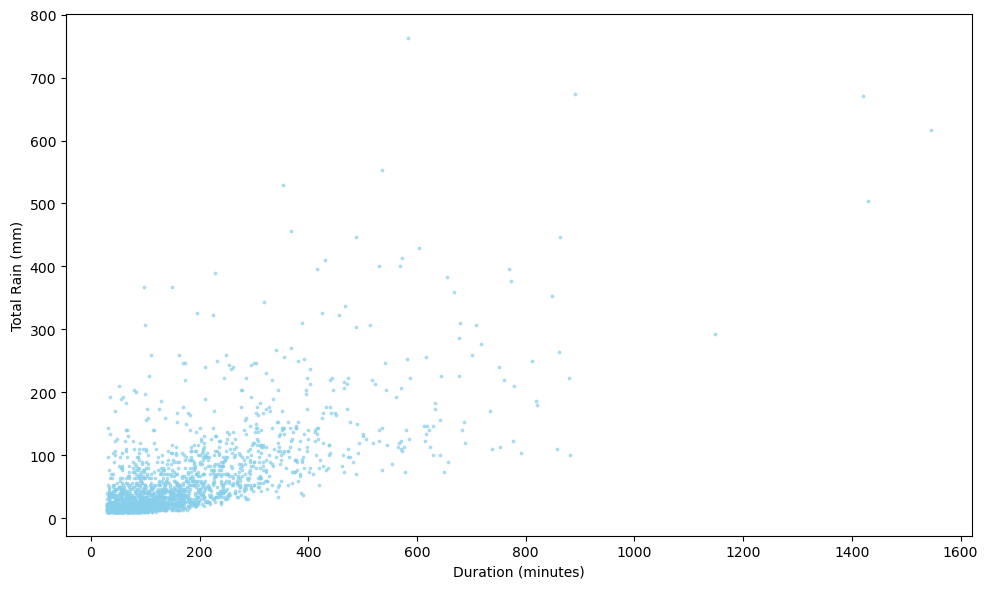

In [18]:
# scattter, total rain as a function of duration
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
ax.scatter(rain_events.duration, rain_events.total_rain, color='skyblue', alpha=0.6, s=3)
ax.set_xlabel('Duration (minutes)')
ax.set_ylabel('Total Rain (mm)')
#ax.set_title('Total Rain vs Duration')
plt.tight_layout()
plt.savefig(save_folder / 'total_rain_vs_duration.png', dpi=100)
plt.show()
plt.close()

## Rain event across time

- year
- month
- hour

In [19]:
rain_events['year'] = rain_events['start'].dt.year
rain_events['month'] = rain_events['start'].dt.month
rain_events['hour'] = rain_events['start'].dt.hour

In [ ]:
def plot_counts(ax, df, column, order=None, kind='bar', color='#9291f3'):

    # Count the occurrences of each category in the specified column
    counts = df[column].value_counts()#.reindex(order)
    
    # if order specified, then reindex
    if order is not None:
        counts = counts.reindex(order)
        # fill na with 0
        counts = counts.fillna(0)
    else:
        # order by key name
        counts = counts.sort_index()

    # Plot the bar chart
    counts.plot(kind=kind, ax=ax, color=color)

    # Add counts on top of each bar
    for i, count in enumerate(counts):
        formatted_count = f"{int(count):,}".replace(',', ' ')
        if kind == 'bar':
            ax.text(i, count, formatted_count, ha='center', va='bottom')
            # rotate x labels
            ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        else:
            ax.text(count, i, formatted_count, ha='left', va='center')
            # invert y-axis
            ax.invert_yaxis()

    # remove y-axis label
    ax.set_ylabel('')
    ax.set_xlabel('')
    return ax

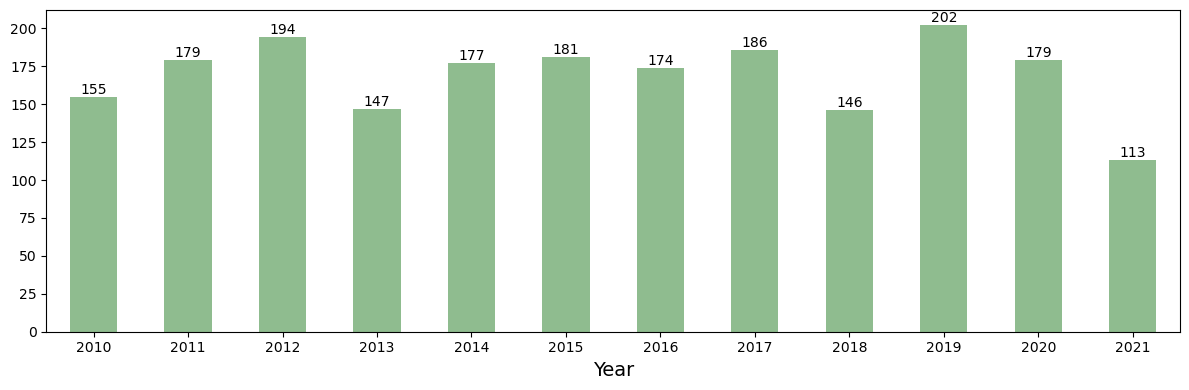

In [21]:
# year
fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
ax = plot_counts(ax, rain_events, 'year', kind='bar', color='darkseagreen')
ax.set_xlabel('Year', fontsize=14)
plt.tight_layout()
plt.savefig(save_folder / 'year_counts.png', dpi=100)
plt.show()
plt.close()

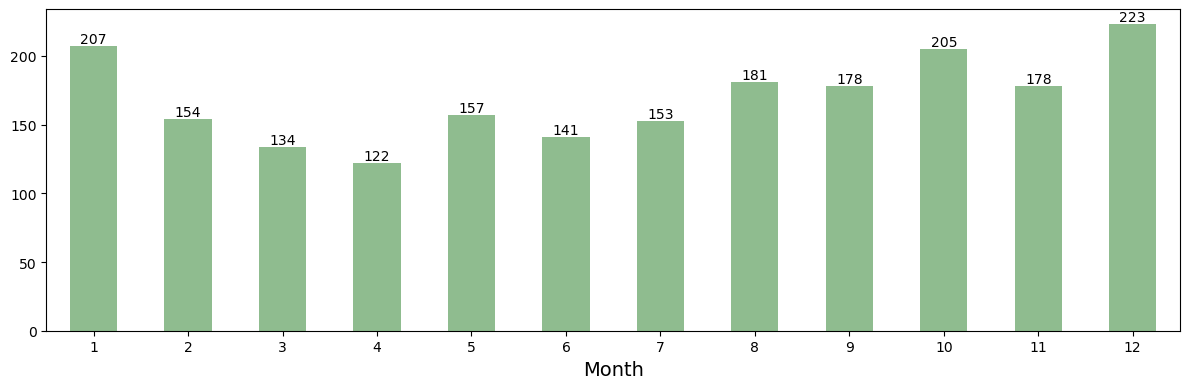

In [22]:
# year
fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
ax = plot_counts(ax, rain_events, 'month', kind='bar', color='darkseagreen')
ax.set_xlabel('Month', fontsize=14)
plt.tight_layout()
plt.savefig(save_folder / 'month_counts.png', dpi=100)
plt.show()
plt.close()

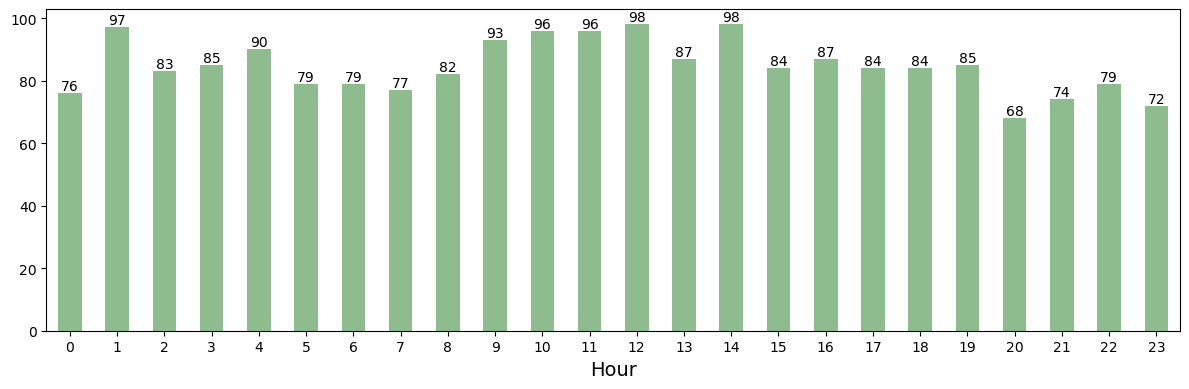

In [23]:
# year
fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
ax = plot_counts(ax, rain_events, 'hour', kind='bar', color='darkseagreen')
ax.set_xlabel('Hour', fontsize=14)
plt.tight_layout()
plt.show()